# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

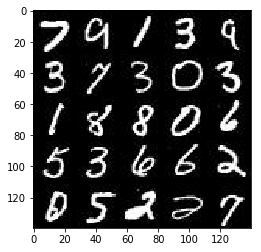

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

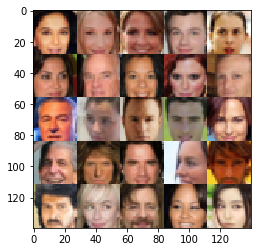

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_image")
    z = tf.placeholder(tf.float32,[None,z_dim],name="z")
    learning_rate = tf.placeholder(tf.float32,[],name="learning_rate")

    return input_image, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False,alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator",reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                                  kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * x1, x1)


        # Hidden Layer 2
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                                  kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)


        # Hidden Layer 3
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                                 kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)

        #Flatten
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):
    # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim, 5,strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - 0.01)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 100
    print_every = 10
    _,i_w,i_h,i_d = data_shape
    input_image, z, _learning_rate = model_inputs(i_w,i_h,i_d,z_dim)
    d_loss,g_loss=model_loss(input_image,z,i_d)
    d_train_opt,g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_image: batch_images, z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_image: batch_images,z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z: batch_z, input_image: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % show_every == 0:
                    show_generator_output(sess,10,z,i_d,data_image_mode)

        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8315... Generator Loss: 0.2395
Epoch 1/2... Discriminator Loss: 5.7252... Generator Loss: 0.0040
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 1.9873... Generator Loss: 0.2851
Epoch 1/2... Discriminator Loss: 3.4747... Generator Loss: 0.0415
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.4389
Epoch 1/2... Discriminator Loss: 0.3859... Generator Loss: 1.8459
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 2.8080... Generator Loss: 0.0813
Epoch 1/2... Discriminator Loss: 2.6883... Generator Loss: 0.1308


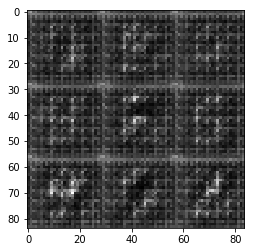

Epoch 1/2... Discriminator Loss: 1.5529... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 4.2525
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.2412
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.4283
Epoch 1/2... Discriminator Loss: 2.3372... Generator Loss: 0.1247
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.0006
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 0.6602


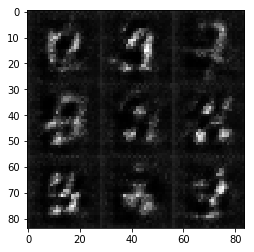

Epoch 1/2... Discriminator Loss: 1.8121... Generator Loss: 0.2073
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.4622
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.3343
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 2.7432
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.8046... Generator Loss: 0.2192
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 0.4759


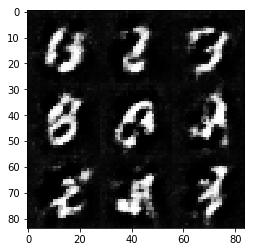

Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 2.4099
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 1.1501
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.5540
Epoch 1/2... Discriminator Loss: 0.6714... Generator Loss: 1.9250
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 1.1734


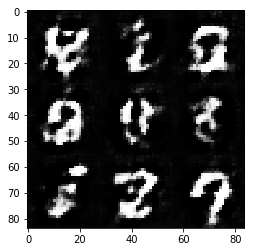

Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 1.7742
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.3067
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 2.2014
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.0023
Epoch 1/2... Discriminator Loss: 0.6706... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 1.6994... Generator Loss: 0.2737
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.5991


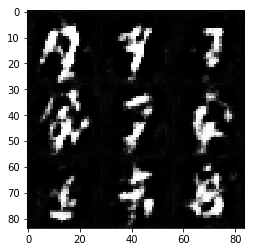

Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 1.3043
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.3843
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 1.9059
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 2.1430
Epoch 1/2... Discriminator Loss: 0.9405... Generator Loss: 0.7403


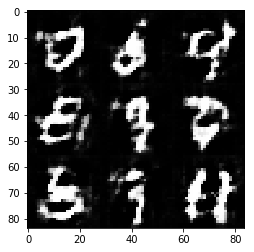

Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 0.7096... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 2.4227... Generator Loss: 0.1153
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 0.5844... Generator Loss: 1.7751
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 2.4932
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 0.8022


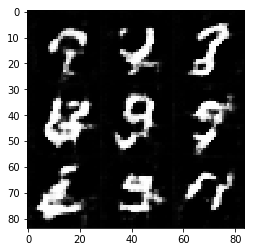

Epoch 1/2... Discriminator Loss: 0.6803... Generator Loss: 1.6296
Epoch 1/2... Discriminator Loss: 0.5944... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.8351... Generator Loss: 0.2372
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 2.0039... Generator Loss: 0.2090
Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.3659


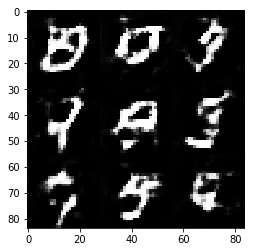

Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.4989
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.8883
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 1.3197
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.4291
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.0885


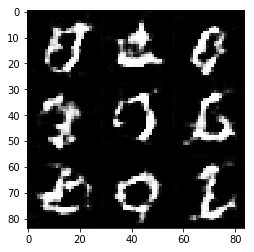

Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 1.9224
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.8417
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 2.2178
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 2.1408
Epoch 1/2... Discriminator Loss: 0.6573... Generator Loss: 2.2758
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.5234
Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 0.8868


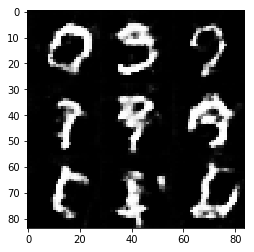

Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 1.9014


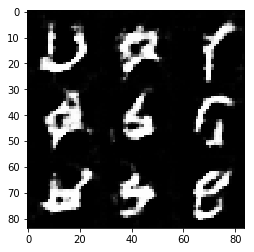

Epoch 1/2... Discriminator Loss: 1.1500... Generator Loss: 1.1778
Epoch 1/2... Discriminator Loss: 1.2464... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.1981
Epoch 1/2... Discriminator Loss: 0.7942... Generator Loss: 1.1376
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 1.5207


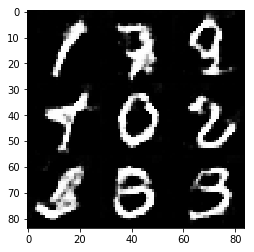

Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.4895
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 2.1611
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 1.3616
Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 0.9701


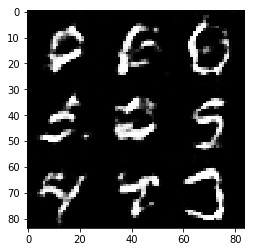

Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 1.4784
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 1.6322
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.4055
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.5535
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 2.8981
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 1.6688
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.3058


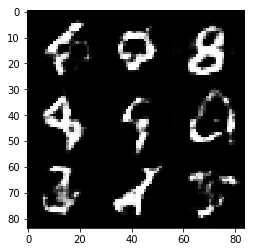

Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 0.7019... Generator Loss: 1.0299
Epoch 1/2... Discriminator Loss: 0.4758... Generator Loss: 1.2758
Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.4555
Epoch 1/2... Discriminator Loss: 2.0500... Generator Loss: 2.4184
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.2670
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 0.7165... Generator Loss: 1.0068


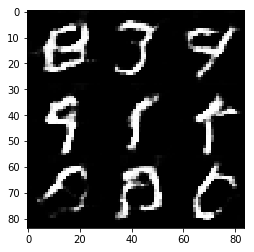

Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 1.3750
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 1.5465
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 0.4860... Generator Loss: 1.6419
Epoch 1/2... Discriminator Loss: 0.5086... Generator Loss: 1.5157
Epoch 1/2... Discriminator Loss: 3.2816... Generator Loss: 0.0524
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.4876


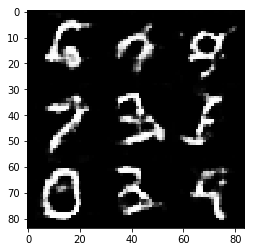

Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 1.1205
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.7204... Generator Loss: 0.3140
Epoch 1/2... Discriminator Loss: 0.5788... Generator Loss: 1.3759
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 3.0361
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 1.7270
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 0.7106


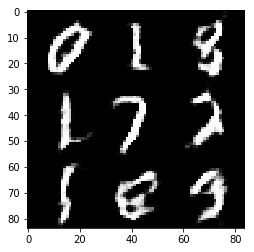

Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.3533
Epoch 1/2... Discriminator Loss: 1.7588... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 0.7387... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.5853... Generator Loss: 1.1691
Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 0.5371


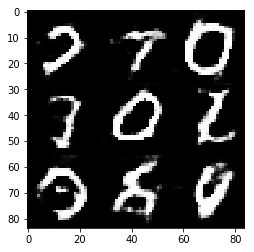

Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.3114
Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 0.2070... Generator Loss: 2.3085
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.4774


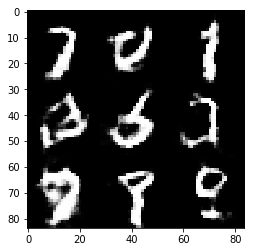

Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 2.1012
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 0.4733... Generator Loss: 1.4608
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 2.6323
Epoch 1/2... Discriminator Loss: 2.0017... Generator Loss: 0.4099
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 1.5737
Epoch 1/2... Discriminator Loss: 0.4855... Generator Loss: 1.6590


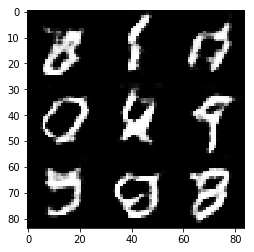

Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.5782
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 1.1106
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 2.3590
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.6167


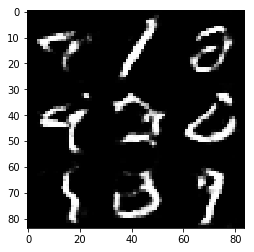

Epoch 1/2... Discriminator Loss: 0.7496... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 1.4207
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 1.1404
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 2.9737... Generator Loss: 0.0829
Epoch 1/2... Discriminator Loss: 0.5045... Generator Loss: 1.2671
Epoch 1/2... Discriminator Loss: 1.9918... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 2.0753
Epoch 1/2... Discriminator Loss: 0.5354... Generator Loss: 1.4298


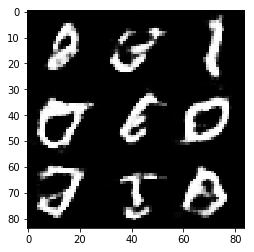

Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 2.3613... Generator Loss: 0.1962
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 0.6983
Epoch 1/2... Discriminator Loss: 0.2340... Generator Loss: 3.5611
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 0.5484
Epoch 1/2... Discriminator Loss: 0.5163... Generator Loss: 1.3104
Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.4204
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 2.0508


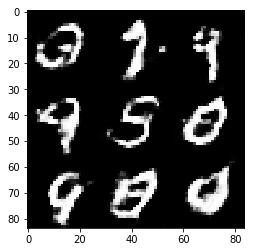

Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 1.7069
Epoch 1/2... Discriminator Loss: 0.3808... Generator Loss: 3.0021
Epoch 1/2... Discriminator Loss: 0.3974... Generator Loss: 1.9681
Epoch 1/2... Discriminator Loss: 1.7456... Generator Loss: 0.3168
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 0.2686... Generator Loss: 2.2634
Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 2.3320
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 0.9716


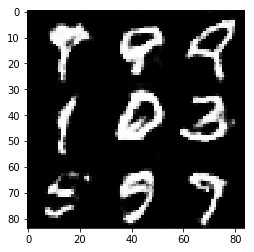

Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 2.3203
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 0.4864... Generator Loss: 1.9703
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 1.0915
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.2634
Epoch 1/2... Discriminator Loss: 0.3000... Generator Loss: 1.8265
Epoch 1/2... Discriminator Loss: 0.4223... Generator Loss: 1.4605


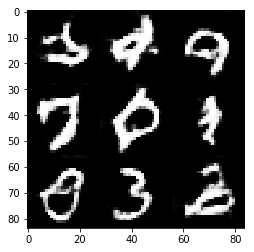

Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 1.5696... Generator Loss: 0.3473
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.4891
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 2.3435
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.5277
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.5448
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 1.5749


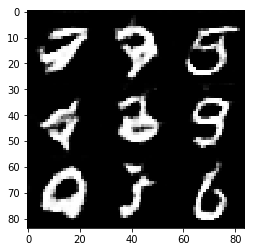

Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 1.4304
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 3.5792
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.9590... Generator Loss: 0.3061
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.7046... Generator Loss: 1.9471
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.9634
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.4138
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 0.4650... Generator Loss: 1.7287


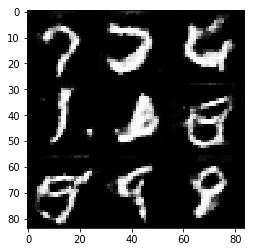

Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 2.3212
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 1.5963
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 0.2841... Generator Loss: 3.0400
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 2.1755
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 1.0863


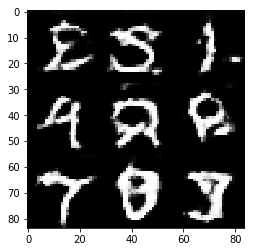

Epoch 1/2... Discriminator Loss: 0.4800... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 0.1946... Generator Loss: 2.6013
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.7327... Generator Loss: 0.3348
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.5695


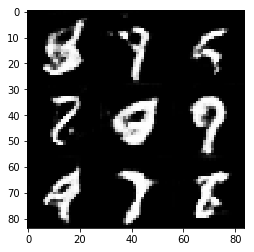

Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 3.4706... Generator Loss: 0.0449
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.3275
Epoch 1/2... Discriminator Loss: 0.3168... Generator Loss: 1.7039
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 2.5178... Generator Loss: 0.1470
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.7205... Generator Loss: 3.8621


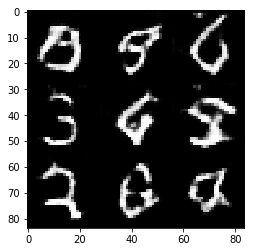

Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 1.6872
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 2.0199... Generator Loss: 0.2190
Epoch 1/2... Discriminator Loss: 0.2453... Generator Loss: 2.4599
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 1.4068
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 1.4255


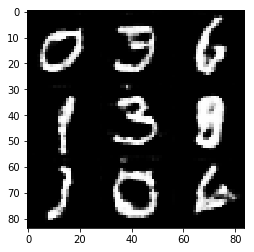

Epoch 1/2... Discriminator Loss: 0.5346... Generator Loss: 1.4740
Epoch 1/2... Discriminator Loss: 0.7171... Generator Loss: 1.1627
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 2.4266
Epoch 1/2... Discriminator Loss: 3.1753... Generator Loss: 0.0583
Epoch 1/2... Discriminator Loss: 0.5332... Generator Loss: 1.2861
Epoch 1/2... Discriminator Loss: 0.2584... Generator Loss: 3.0151
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 0.8194
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 1.8454
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.5419


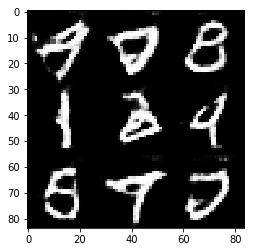

Epoch 1/2... Discriminator Loss: 1.6700... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 0.2118... Generator Loss: 3.1285
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 3.7536
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.3372
Epoch 1/2... Discriminator Loss: 0.4720... Generator Loss: 2.1391
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 0.9856
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 2.1517


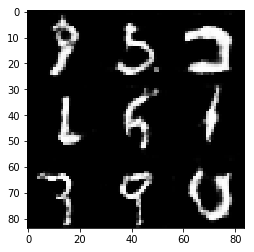

Epoch 1/2... Discriminator Loss: 0.4664... Generator Loss: 2.0946
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 3.0247
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.4996
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.3059
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.1904


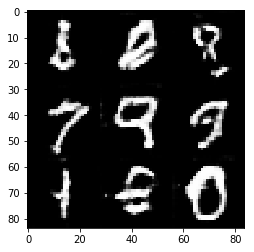

Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 1.4757
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 1.6912
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 2.9475
Epoch 1/2... Discriminator Loss: 0.5234... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.0132


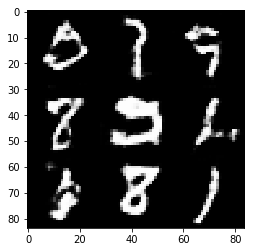

Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 0.6418... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 0.5121... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 3.2402
Epoch 1/2... Discriminator Loss: 2.6045... Generator Loss: 0.1200
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.6642
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 2.6048
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 1.3291


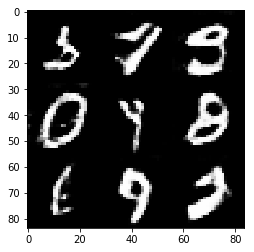

Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.7226... Generator Loss: 5.5121
Epoch 1/2... Discriminator Loss: 0.1866... Generator Loss: 3.0205
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.8451... Generator Loss: 0.2630
Epoch 1/2... Discriminator Loss: 0.3707... Generator Loss: 1.7594
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 0.2017... Generator Loss: 2.4561
Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 0.8008


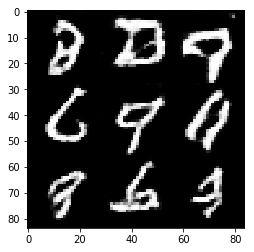

Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.3425
Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 1.2866
Epoch 1/2... Discriminator Loss: 0.2577... Generator Loss: 1.9732
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 1.7311
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 1.6940
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 1.3804


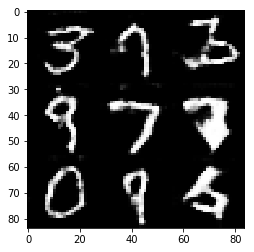

Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.9550
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 0.5820... Generator Loss: 1.2559
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 1.5958
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 1.3939
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 0.7673... Generator Loss: 0.7841


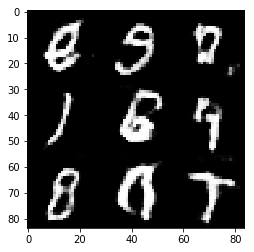

Epoch 1/2... Discriminator Loss: 0.2399... Generator Loss: 2.3587
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.2498
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 0.7126... Generator Loss: 0.8565
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 3.5866
Epoch 1/2... Discriminator Loss: 0.4683... Generator Loss: 1.2946


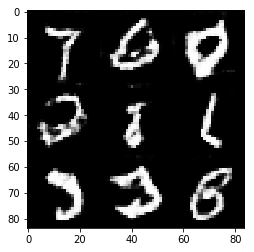

Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 0.6002... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.0131
Epoch 1/2... Discriminator Loss: 0.5099... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 1.8848... Generator Loss: 0.2153
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 0.4543... Generator Loss: 1.6829
Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.5064


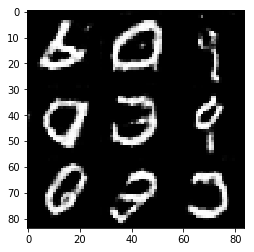

Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 1.5950
Epoch 1/2... Discriminator Loss: 0.1716... Generator Loss: 2.8152
Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 1.9325
Epoch 1/2... Discriminator Loss: 0.8824... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 1.7637
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 1.2939


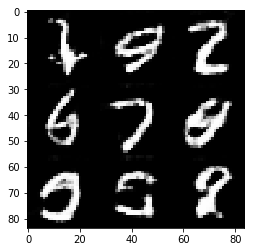

Epoch 1/2... Discriminator Loss: 0.3409... Generator Loss: 1.6779
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.4749
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 0.2532... Generator Loss: 2.0175
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 0.3218... Generator Loss: 2.6834
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 1.4594
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 0.4361... Generator Loss: 1.6544


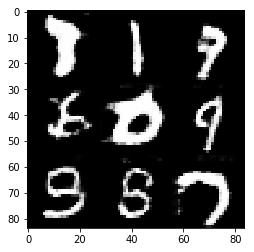

Epoch 1/2... Discriminator Loss: 2.2729... Generator Loss: 0.3628
Epoch 1/2... Discriminator Loss: 0.3239... Generator Loss: 4.1362
Epoch 1/2... Discriminator Loss: 0.2256... Generator Loss: 3.4261
Epoch 1/2... Discriminator Loss: 0.3523... Generator Loss: 1.8599
Epoch 1/2... Discriminator Loss: 0.4145... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 2.0737... Generator Loss: 0.2984
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 1.9119
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.3056
Epoch 1/2... Discriminator Loss: 0.2913... Generator Loss: 2.1880


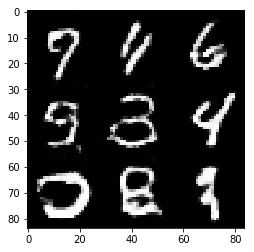

Epoch 1/2... Discriminator Loss: 0.3057... Generator Loss: 1.8778
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 1.4368
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 0.0987... Generator Loss: 4.7191
Epoch 1/2... Discriminator Loss: 0.7340... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 0.6100... Generator Loss: 1.3618
Epoch 1/2... Discriminator Loss: 0.3074... Generator Loss: 2.2118
Epoch 1/2... Discriminator Loss: 0.3472... Generator Loss: 1.8795
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 1.2275


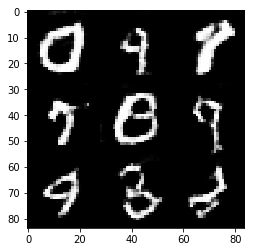

Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 1.4866
Epoch 1/2... Discriminator Loss: 0.2412... Generator Loss: 2.2056
Epoch 1/2... Discriminator Loss: 0.2269... Generator Loss: 2.8280
Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 4.0998
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 0.8716
Epoch 1/2... Discriminator Loss: 0.2903... Generator Loss: 2.0139
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 0.5182... Generator Loss: 1.7388
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 1.2131


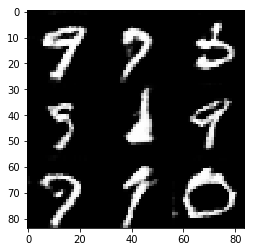

Epoch 1/2... Discriminator Loss: 0.8076... Generator Loss: 1.0304
Epoch 1/2... Discriminator Loss: 0.2759... Generator Loss: 1.9961
Epoch 1/2... Discriminator Loss: 0.3360... Generator Loss: 3.8611
Epoch 1/2... Discriminator Loss: 1.2781... Generator Loss: 0.5617
Epoch 1/2... Discriminator Loss: 0.3917... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.4798
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 1.6172
Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 1.9041
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 2.0929


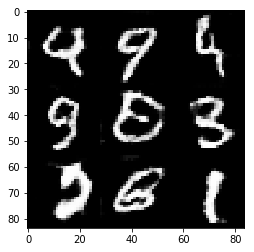

Epoch 1/2... Discriminator Loss: 0.3092... Generator Loss: 2.0622
Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 0.3765... Generator Loss: 1.8123
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 0.2675... Generator Loss: 2.0096
Epoch 1/2... Discriminator Loss: 0.8470... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 0.5435... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.1201
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.5047


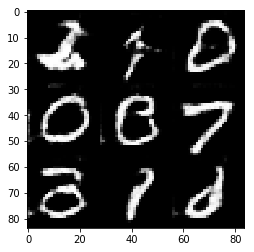

Epoch 1/2... Discriminator Loss: 0.6258... Generator Loss: 1.2299
Epoch 1/2... Discriminator Loss: 0.6099... Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 0.2240... Generator Loss: 2.0746
Epoch 1/2... Discriminator Loss: 0.6802... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 0.2794... Generator Loss: 2.1432
Epoch 1/2... Discriminator Loss: 0.2790... Generator Loss: 1.9169
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 1.7458
Epoch 1/2... Discriminator Loss: 0.2944... Generator Loss: 1.8446
Epoch 1/2... Discriminator Loss: 1.7169... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.6076


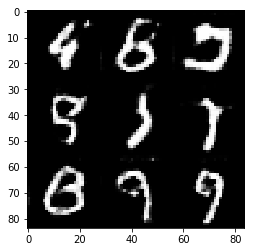

Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 3.2061
Epoch 1/2... Discriminator Loss: 0.2348... Generator Loss: 2.7219
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.1248
Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 2.4529
Epoch 1/2... Discriminator Loss: 0.3173... Generator Loss: 1.8445
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 2.3084
Epoch 1/2... Discriminator Loss: 0.2887... Generator Loss: 2.6924
Epoch 1/2... Discriminator Loss: 0.4315... Generator Loss: 2.0660
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.1968
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.3113


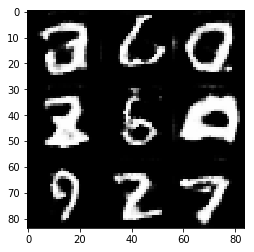

Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.0710
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 1.9144
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 1.3444
Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 1.3972
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 1.6356
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 1.0840


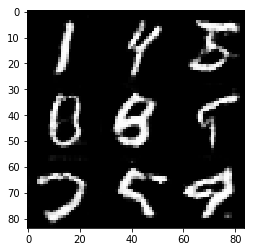

Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 1.9964
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 0.5428... Generator Loss: 1.4601
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 2.0333
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.5066
Epoch 1/2... Discriminator Loss: 0.3224... Generator Loss: 1.7786
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.5099


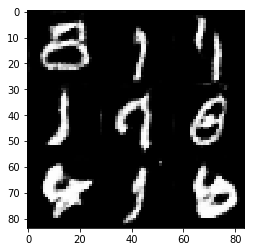

Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 1.4805
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.4845
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 1.8622
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.6575
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 0.7720... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.3754


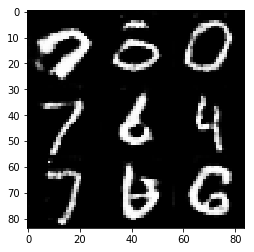

Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 1.6746
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 2.6074
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.5535
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 0.5286... Generator Loss: 1.2882
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 1.1349
Epoch 1/2... Discriminator Loss: 0.2887... Generator Loss: 2.0812
Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 1.0681


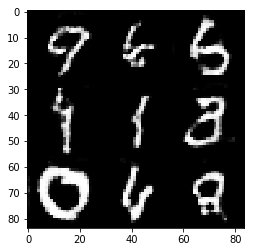

Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 2.2322
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 1.6981
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 4.3110
Epoch 1/2... Discriminator Loss: 0.2174... Generator Loss: 2.3753
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 0.3136... Generator Loss: 1.8944
Epoch 1/2... Discriminator Loss: 0.4883... Generator Loss: 1.4767
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 1.3683
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 1.4214
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 0.8690


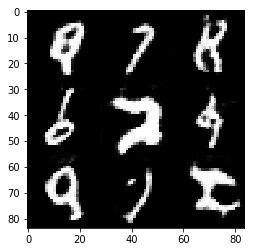

Epoch 1/2... Discriminator Loss: 0.2403... Generator Loss: 2.0479
Epoch 1/2... Discriminator Loss: 0.1838... Generator Loss: 2.6839
Epoch 1/2... Discriminator Loss: 0.2571... Generator Loss: 2.1632
Epoch 1/2... Discriminator Loss: 0.2217... Generator Loss: 2.4196
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 1.4517
Epoch 1/2... Discriminator Loss: 0.2854... Generator Loss: 2.1150
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 0.8779
Epoch 1/2... Discriminator Loss: 0.8125... Generator Loss: 1.1892


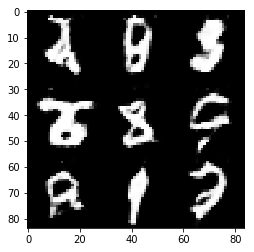

Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 1.7906
Epoch 1/2... Discriminator Loss: 0.4345... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 1.5265... Generator Loss: 0.4499
Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.2165
Epoch 1/2... Discriminator Loss: 0.6482... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 2.1232
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 1.9292
Epoch 1/2... Discriminator Loss: 0.4595... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 0.8677


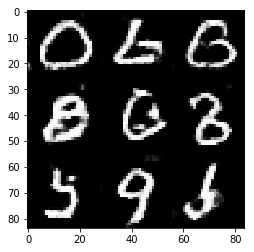

Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 0.1938... Generator Loss: 5.3705
Epoch 1/2... Discriminator Loss: 0.5866... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 0.4899... Generator Loss: 1.6026
Epoch 1/2... Discriminator Loss: 0.1031... Generator Loss: 3.6772
Epoch 1/2... Discriminator Loss: 0.2327... Generator Loss: 2.1777
Epoch 1/2... Discriminator Loss: 0.6284... Generator Loss: 1.8064
Epoch 1/2... Discriminator Loss: 1.7228... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.3010


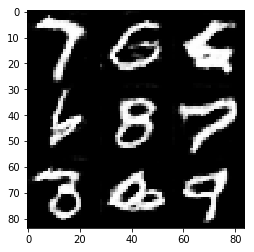

Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.3335
Epoch 1/2... Discriminator Loss: 0.1919... Generator Loss: 2.4131
Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.1446... Generator Loss: 3.4441
Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 2.4894
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 2.0718
Epoch 1/2... Discriminator Loss: 0.1754... Generator Loss: 2.7124
Epoch 1/2... Discriminator Loss: 0.5992... Generator Loss: 1.5422
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9674


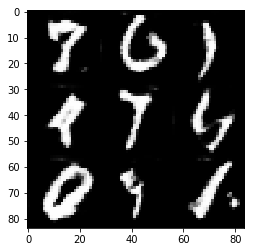

Epoch 1/2... Discriminator Loss: 0.2806... Generator Loss: 2.1567
Epoch 1/2... Discriminator Loss: 0.3980... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 0.1883... Generator Loss: 2.6212
Epoch 1/2... Discriminator Loss: 0.4817... Generator Loss: 1.7319
Epoch 1/2... Discriminator Loss: 0.2395... Generator Loss: 2.3165
Epoch 1/2... Discriminator Loss: 0.5208... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 1.6429
Epoch 1/2... Discriminator Loss: 0.1639... Generator Loss: 3.1468


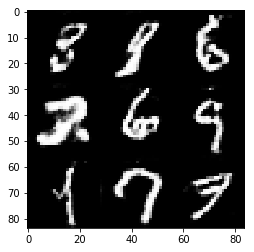

Epoch 2/2... Discriminator Loss: 0.2813... Generator Loss: 1.9911
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 2.6681
Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 1.4664
Epoch 2/2... Discriminator Loss: 0.4546... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.1646... Generator Loss: 2.4770
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 1.9748
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 1.6953
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 1.4672


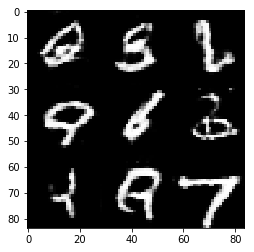

Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 0.5780... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 0.4954... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.4732
Epoch 2/2... Discriminator Loss: 0.2102... Generator Loss: 2.4260
Epoch 2/2... Discriminator Loss: 0.2114... Generator Loss: 4.1618
Epoch 2/2... Discriminator Loss: 0.3208... Generator Loss: 2.2275
Epoch 2/2... Discriminator Loss: 0.2955... Generator Loss: 4.2079


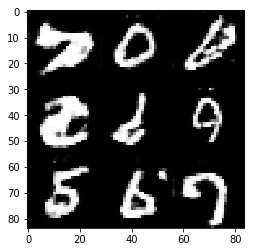

Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.1685
Epoch 2/2... Discriminator Loss: 0.2987... Generator Loss: 2.0041
Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.1175
Epoch 2/2... Discriminator Loss: 0.3745... Generator Loss: 1.8567
Epoch 2/2... Discriminator Loss: 0.2009... Generator Loss: 2.8495
Epoch 2/2... Discriminator Loss: 0.1970... Generator Loss: 3.0101
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 3.2062
Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 1.8650
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.0935


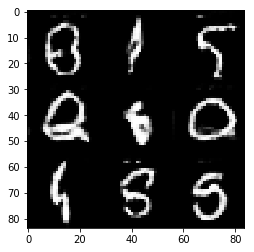

Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 1.8551
Epoch 2/2... Discriminator Loss: 0.2636... Generator Loss: 3.8540
Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 1.5693
Epoch 2/2... Discriminator Loss: 0.2226... Generator Loss: 2.6951
Epoch 2/2... Discriminator Loss: 0.3289... Generator Loss: 1.7977
Epoch 2/2... Discriminator Loss: 0.4113... Generator Loss: 1.9055
Epoch 2/2... Discriminator Loss: 0.1350... Generator Loss: 3.2849
Epoch 2/2... Discriminator Loss: 0.2777... Generator Loss: 2.0093


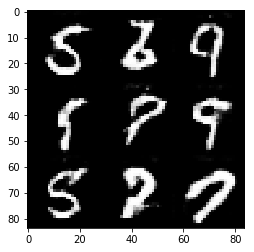

Epoch 2/2... Discriminator Loss: 0.7505... Generator Loss: 2.5783
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 1.9239
Epoch 2/2... Discriminator Loss: 0.1860... Generator Loss: 2.6741
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 2.0141
Epoch 2/2... Discriminator Loss: 0.3009... Generator Loss: 1.9393
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 0.2785... Generator Loss: 2.2276
Epoch 2/2... Discriminator Loss: 0.2854... Generator Loss: 1.9475
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.0629


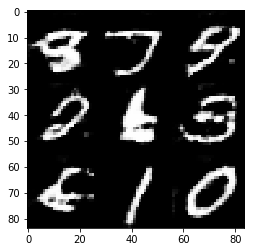

Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 1.8381
Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 1.7742
Epoch 2/2... Discriminator Loss: 0.5489... Generator Loss: 1.3782
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.1076
Epoch 2/2... Discriminator Loss: 1.8540... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 0.3753... Generator Loss: 2.2478
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 2.4009
Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 2.8108
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 0.7914


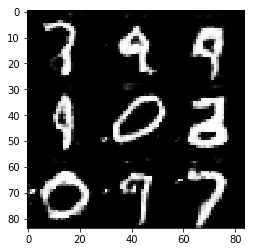

Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.5265
Epoch 2/2... Discriminator Loss: 0.2220... Generator Loss: 2.2851
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 0.4453... Generator Loss: 1.5466
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 0.2471... Generator Loss: 3.5915
Epoch 2/2... Discriminator Loss: 0.5355... Generator Loss: 1.4746
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 1.3465
Epoch 2/2... Discriminator Loss: 0.2994... Generator Loss: 2.5646


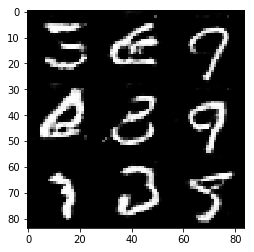

Epoch 2/2... Discriminator Loss: 3.0896... Generator Loss: 0.2616
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 3.2006
Epoch 2/2... Discriminator Loss: 0.1997... Generator Loss: 2.7153
Epoch 2/2... Discriminator Loss: 0.4636... Generator Loss: 1.7676
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.1935
Epoch 2/2... Discriminator Loss: 0.1636... Generator Loss: 2.7828
Epoch 2/2... Discriminator Loss: 0.3698... Generator Loss: 1.7548
Epoch 2/2... Discriminator Loss: 0.1757... Generator Loss: 3.3664
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 3.1033


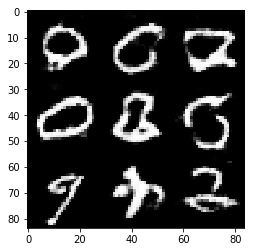

Epoch 2/2... Discriminator Loss: 0.2276... Generator Loss: 2.8262
Epoch 2/2... Discriminator Loss: 0.1902... Generator Loss: 2.9372
Epoch 2/2... Discriminator Loss: 0.3187... Generator Loss: 1.9645
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.4991
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.3589
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.2068


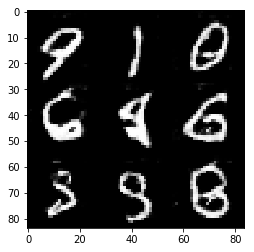

Epoch 2/2... Discriminator Loss: 0.6058... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 0.2326... Generator Loss: 3.4474
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 2.1942
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 1.4690
Epoch 2/2... Discriminator Loss: 0.2395... Generator Loss: 2.4938
Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 1.3489
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.7885
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 2.2510
Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.1915


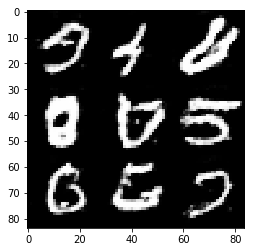

Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 1.4024
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 7.4433
Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 0.1419... Generator Loss: 3.4569
Epoch 2/2... Discriminator Loss: 0.2298... Generator Loss: 2.9546
Epoch 2/2... Discriminator Loss: 0.3089... Generator Loss: 1.9041
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 1.8947
Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 0.5988... Generator Loss: 1.1430


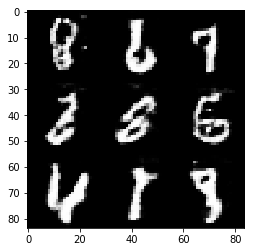

Epoch 2/2... Discriminator Loss: 0.1567... Generator Loss: 4.3019
Epoch 2/2... Discriminator Loss: 0.5555... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 1.8856
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 1.5410
Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 2.9837
Epoch 2/2... Discriminator Loss: 0.1194... Generator Loss: 3.4130
Epoch 2/2... Discriminator Loss: 0.4711... Generator Loss: 1.4021
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 5.2694
Epoch 2/2... Discriminator Loss: 0.2705... Generator Loss: 2.9701
Epoch 2/2... Discriminator Loss: 0.3059... Generator Loss: 3.2588


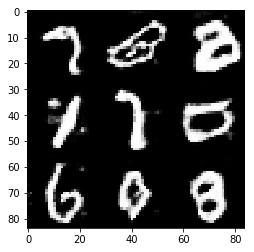

Epoch 2/2... Discriminator Loss: 0.3364... Generator Loss: 2.0510
Epoch 2/2... Discriminator Loss: 0.1353... Generator Loss: 3.4328
Epoch 2/2... Discriminator Loss: 0.2728... Generator Loss: 2.4016
Epoch 2/2... Discriminator Loss: 0.2206... Generator Loss: 2.0415
Epoch 2/2... Discriminator Loss: 0.5433... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 5.3076
Epoch 2/2... Discriminator Loss: 0.3054... Generator Loss: 2.2354
Epoch 2/2... Discriminator Loss: 0.5672... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.1221


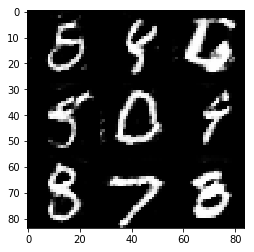

Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 1.4289
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 2.0464
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 3.4066... Generator Loss: 0.0809
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 0.4509... Generator Loss: 1.6790
Epoch 2/2... Discriminator Loss: 0.1982... Generator Loss: 3.1780
Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 1.3198


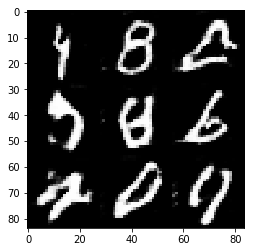

Epoch 2/2... Discriminator Loss: 0.2675... Generator Loss: 2.2418
Epoch 2/2... Discriminator Loss: 0.2028... Generator Loss: 2.6656
Epoch 2/2... Discriminator Loss: 0.6078... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 0.2237... Generator Loss: 2.6890
Epoch 2/2... Discriminator Loss: 0.3279... Generator Loss: 1.8681
Epoch 2/2... Discriminator Loss: 2.6501... Generator Loss: 0.1506
Epoch 2/2... Discriminator Loss: 0.3818... Generator Loss: 2.1456
Epoch 2/2... Discriminator Loss: 0.1866... Generator Loss: 2.4979
Epoch 2/2... Discriminator Loss: 0.3787... Generator Loss: 3.2551


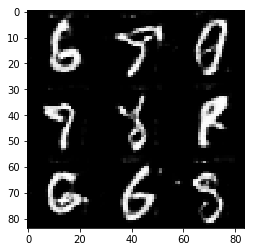

Epoch 2/2... Discriminator Loss: 0.3705... Generator Loss: 1.7696
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.3109
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.3674
Epoch 2/2... Discriminator Loss: 0.3107... Generator Loss: 2.6932
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.2018... Generator Loss: 2.3932
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 0.8309


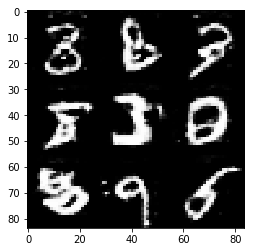

Epoch 2/2... Discriminator Loss: 0.1214... Generator Loss: 3.8190
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 0.9894
Epoch 2/2... Discriminator Loss: 0.3074... Generator Loss: 1.8729
Epoch 2/2... Discriminator Loss: 0.1398... Generator Loss: 3.1815
Epoch 2/2... Discriminator Loss: 0.2181... Generator Loss: 2.3992
Epoch 2/2... Discriminator Loss: 0.3702... Generator Loss: 1.6164
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 3.7150
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 0.9670


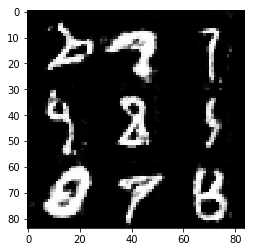

Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.4082
Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 6.7264
Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 2.6672
Epoch 2/2... Discriminator Loss: 0.3113... Generator Loss: 1.9164
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 0.4412... Generator Loss: 1.7056
Epoch 2/2... Discriminator Loss: 2.0712... Generator Loss: 0.2019
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 0.2487... Generator Loss: 2.4196


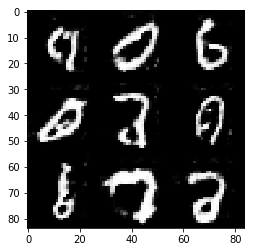

Epoch 2/2... Discriminator Loss: 0.1612... Generator Loss: 2.5843
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 0.1818... Generator Loss: 2.4573
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.2869... Generator Loss: 1.8733
Epoch 2/2... Discriminator Loss: 0.1044... Generator Loss: 3.8564
Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 1.7121
Epoch 2/2... Discriminator Loss: 0.5468... Generator Loss: 1.4872
Epoch 2/2... Discriminator Loss: 0.1388... Generator Loss: 3.2591
Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 0.8968


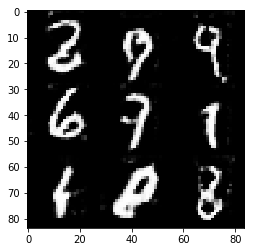

Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 0.1270... Generator Loss: 3.4288
Epoch 2/2... Discriminator Loss: 0.4397... Generator Loss: 1.5948
Epoch 2/2... Discriminator Loss: 0.2494... Generator Loss: 3.0896
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 0.2909... Generator Loss: 1.8921
Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 2.9857
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.2920... Generator Loss: 2.2889


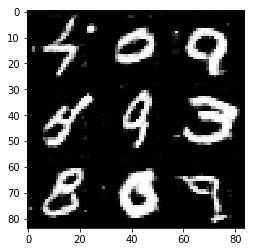

Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 3.1033
Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 2.5788
Epoch 2/2... Discriminator Loss: 0.2991... Generator Loss: 2.1317
Epoch 2/2... Discriminator Loss: 0.1790... Generator Loss: 2.6479
Epoch 2/2... Discriminator Loss: 0.1784... Generator Loss: 3.0906
Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 2.0641
Epoch 2/2... Discriminator Loss: 0.2337... Generator Loss: 3.2281
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 0.1813... Generator Loss: 3.3193
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.0266


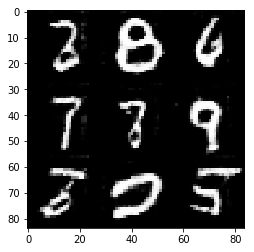

Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.4776
Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 1.7579
Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 2.0362
Epoch 2/2... Discriminator Loss: 0.2043... Generator Loss: 2.1928
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 1.0843
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 1.5534
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 3.0298
Epoch 2/2... Discriminator Loss: 0.2961... Generator Loss: 1.7201
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 1.5065


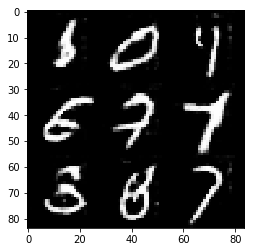

Epoch 2/2... Discriminator Loss: 2.1634... Generator Loss: 0.5053
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 4.6532
Epoch 2/2... Discriminator Loss: 0.2573... Generator Loss: 2.6953
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 3.7601
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 0.3877... Generator Loss: 1.8360
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 0.3504... Generator Loss: 1.7210
Epoch 2/2... Discriminator Loss: 0.3785... Generator Loss: 1.7504
Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 1.6951


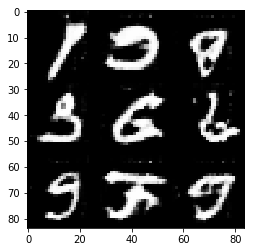

Epoch 2/2... Discriminator Loss: 1.6937... Generator Loss: 0.3080
Epoch 2/2... Discriminator Loss: 0.4651... Generator Loss: 1.9711
Epoch 2/2... Discriminator Loss: 0.3307... Generator Loss: 2.0247
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 1.5823
Epoch 2/2... Discriminator Loss: 0.2718... Generator Loss: 2.7210
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.0594
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 2.4561
Epoch 2/2... Discriminator Loss: 0.3745... Generator Loss: 1.9727
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.0350


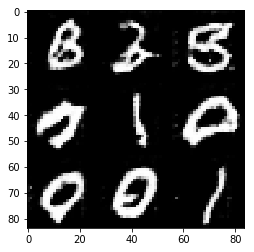

Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.1160... Generator Loss: 3.7624
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.4156
Epoch 2/2... Discriminator Loss: 1.9993... Generator Loss: 0.4020
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.0174
Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 5.7738
Epoch 2/2... Discriminator Loss: 0.3961... Generator Loss: 1.7749


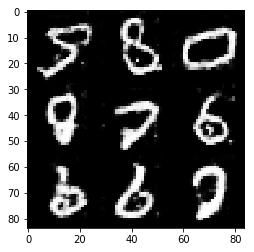

Epoch 2/2... Discriminator Loss: 0.4659... Generator Loss: 1.4059
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 2.1721
Epoch 2/2... Discriminator Loss: 0.5282... Generator Loss: 1.7632
Epoch 2/2... Discriminator Loss: 0.1362... Generator Loss: 3.8014
Epoch 2/2... Discriminator Loss: 0.5641... Generator Loss: 1.2246
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.1565
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 1.5898
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 0.4812... Generator Loss: 1.6452
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.2630


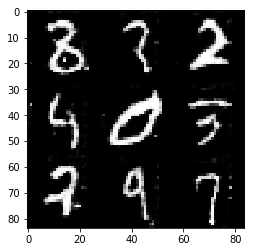

Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 1.9907
Epoch 2/2... Discriminator Loss: 0.4106... Generator Loss: 1.8651
Epoch 2/2... Discriminator Loss: 2.5758... Generator Loss: 0.3747
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.0835
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.6429
Epoch 2/2... Discriminator Loss: 0.1734... Generator Loss: 3.0758
Epoch 2/2... Discriminator Loss: 1.8250... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 1.9333
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.8077


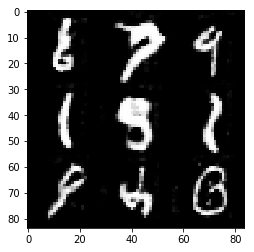

Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.8816
Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 1.9021
Epoch 2/2... Discriminator Loss: 0.4408... Generator Loss: 1.7358
Epoch 2/2... Discriminator Loss: 0.1917... Generator Loss: 2.6045
Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 1.0730
Epoch 2/2... Discriminator Loss: 0.1294... Generator Loss: 3.1012
Epoch 2/2... Discriminator Loss: 0.2537... Generator Loss: 2.1750
Epoch 2/2... Discriminator Loss: 0.1772... Generator Loss: 4.5420
Epoch 2/2... Discriminator Loss: 0.3169... Generator Loss: 2.5461
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 0.8154


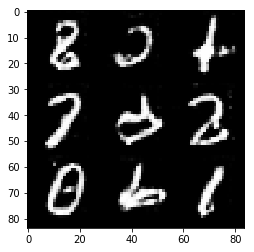

Epoch 2/2... Discriminator Loss: 0.0883... Generator Loss: 4.2741
Epoch 2/2... Discriminator Loss: 0.3288... Generator Loss: 2.2807
Epoch 2/2... Discriminator Loss: 0.3240... Generator Loss: 2.0028
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 0.5913
Epoch 2/2... Discriminator Loss: 0.1087... Generator Loss: 3.3570
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 0.4068... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.2955... Generator Loss: 2.0580
Epoch 2/2... Discriminator Loss: 0.1886... Generator Loss: 2.6831
Epoch 2/2... Discriminator Loss: 0.3705... Generator Loss: 1.7936


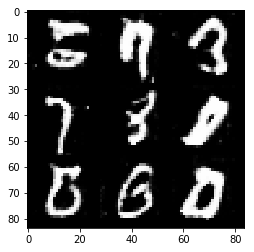

Epoch 2/2... Discriminator Loss: 0.1332... Generator Loss: 2.8860
Epoch 2/2... Discriminator Loss: 1.5846... Generator Loss: 0.4547
Epoch 2/2... Discriminator Loss: 0.1936... Generator Loss: 2.6058
Epoch 2/2... Discriminator Loss: 0.1996... Generator Loss: 2.7030
Epoch 2/2... Discriminator Loss: 0.3005... Generator Loss: 1.6651
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.2284
Epoch 2/2... Discriminator Loss: 0.2337... Generator Loss: 2.2844
Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 1.9326
Epoch 2/2... Discriminator Loss: 1.7452... Generator Loss: 0.3548
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.3840


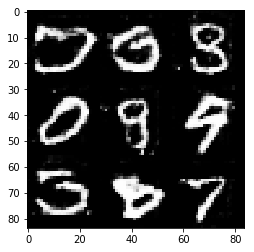

Epoch 2/2... Discriminator Loss: 0.1992... Generator Loss: 2.6610
Epoch 2/2... Discriminator Loss: 0.5332... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.5305
Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 2.0048
Epoch 2/2... Discriminator Loss: 0.7913... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.9796
Epoch 2/2... Discriminator Loss: 0.1437... Generator Loss: 2.9413
Epoch 2/2... Discriminator Loss: 0.3538... Generator Loss: 1.4192
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 1.5661


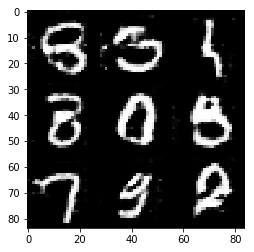

Epoch 2/2... Discriminator Loss: 0.6123... Generator Loss: 1.0044
Epoch 2/2... Discriminator Loss: 0.2928... Generator Loss: 2.6207
Epoch 2/2... Discriminator Loss: 0.2203... Generator Loss: 2.8528
Epoch 2/2... Discriminator Loss: 0.3211... Generator Loss: 2.3063
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 0.3077... Generator Loss: 2.0087
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.2650
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 0.2014... Generator Loss: 2.6332


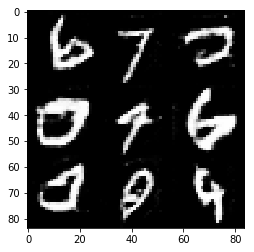

Epoch 2/2... Discriminator Loss: 0.4527... Generator Loss: 1.5795
Epoch 2/2... Discriminator Loss: 0.7196... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 0.1815... Generator Loss: 3.3897
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.1860... Generator Loss: 2.7963
Epoch 2/2... Discriminator Loss: 0.1787... Generator Loss: 2.4746
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 1.8502


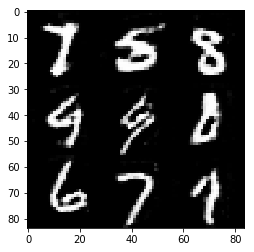

Epoch 2/2... Discriminator Loss: 0.7737... Generator Loss: 0.9097
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 2.5813
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.4983... Generator Loss: 1.4657
Epoch 2/2... Discriminator Loss: 0.4937... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.4434... Generator Loss: 1.2415


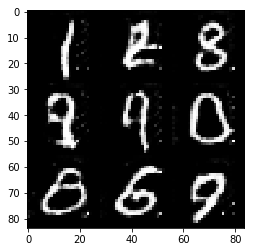

Epoch 2/2... Discriminator Loss: 0.2717... Generator Loss: 2.1332
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 3.4808
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 5.8349
Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 2.3169
Epoch 2/2... Discriminator Loss: 2.6564... Generator Loss: 6.3039
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.6528
Epoch 2/2... Discriminator Loss: 0.2558... Generator Loss: 3.1931
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 2.2521
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 1.5756


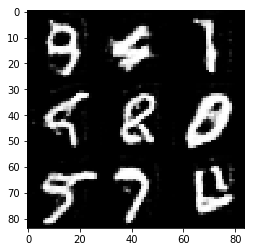

Epoch 2/2... Discriminator Loss: 0.2658... Generator Loss: 2.4501
Epoch 2/2... Discriminator Loss: 0.2754... Generator Loss: 2.2312
Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 1.6106
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.2661
Epoch 2/2... Discriminator Loss: 1.9524... Generator Loss: 0.2282
Epoch 2/2... Discriminator Loss: 0.4510... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 1.5052
Epoch 2/2... Discriminator Loss: 0.4130... Generator Loss: 1.4760
Epoch 2/2... Discriminator Loss: 0.2919... Generator Loss: 2.5623
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.8940


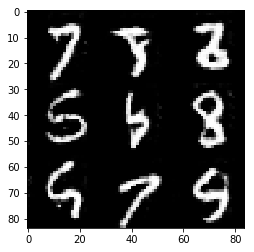

Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 1.6716
Epoch 2/2... Discriminator Loss: 0.6078... Generator Loss: 1.2362
Epoch 2/2... Discriminator Loss: 0.3818... Generator Loss: 1.9704
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 5.0481
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.5819
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 0.1260... Generator Loss: 4.2697
Epoch 2/2... Discriminator Loss: 0.2832... Generator Loss: 2.0183
Epoch 2/2... Discriminator Loss: 0.1125... Generator Loss: 3.5380
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.0790


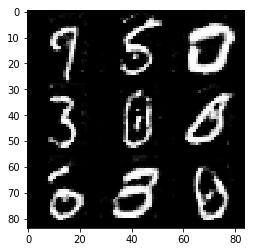

Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 1.1326
Epoch 2/2... Discriminator Loss: 0.1621... Generator Loss: 4.7817
Epoch 2/2... Discriminator Loss: 0.0979... Generator Loss: 4.3272
Epoch 2/2... Discriminator Loss: 0.2843... Generator Loss: 2.3243
Epoch 2/2... Discriminator Loss: 0.2815... Generator Loss: 2.3541
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.0790
Epoch 2/2... Discriminator Loss: 0.4595... Generator Loss: 1.2344
Epoch 2/2... Discriminator Loss: 0.1891... Generator Loss: 2.4388
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 1.0440


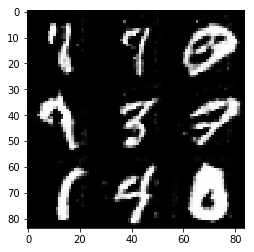

Epoch 2/2... Discriminator Loss: 0.3140... Generator Loss: 1.8725
Epoch 2/2... Discriminator Loss: 0.2724... Generator Loss: 2.0634
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 0.9489
Epoch 2/2... Discriminator Loss: 0.1678... Generator Loss: 2.7115
Epoch 2/2... Discriminator Loss: 0.1630... Generator Loss: 2.6781
Epoch 2/2... Discriminator Loss: 0.2298... Generator Loss: 2.5870
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 5.2105
Epoch 2/2... Discriminator Loss: 0.4101... Generator Loss: 1.4037


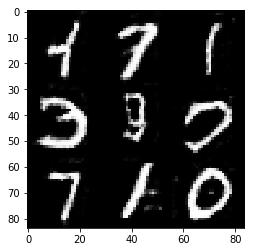

Epoch 2/2... Discriminator Loss: 0.3429... Generator Loss: 1.6394
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.5239
Epoch 2/2... Discriminator Loss: 0.3203... Generator Loss: 2.6174
Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 1.7923
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 1.4643
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 1.8115
Epoch 2/2... Discriminator Loss: 0.4076... Generator Loss: 1.5339
Epoch 2/2... Discriminator Loss: 0.3022... Generator Loss: 1.9190


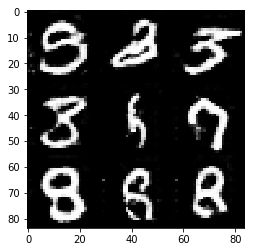

Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 2.0194
Epoch 2/2... Discriminator Loss: 0.2931... Generator Loss: 2.4472
Epoch 2/2... Discriminator Loss: 0.3219... Generator Loss: 2.4991
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.4322... Generator Loss: 1.5195
Epoch 2/2... Discriminator Loss: 1.8774... Generator Loss: 0.2650
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 3.0635
Epoch 2/2... Discriminator Loss: 0.1453... Generator Loss: 3.3874
Epoch 2/2... Discriminator Loss: 0.4635... Generator Loss: 1.6343


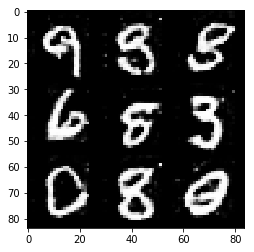

Epoch 2/2... Discriminator Loss: 0.2146... Generator Loss: 2.2246
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 0.1391... Generator Loss: 2.9795
Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 3.5127
Epoch 2/2... Discriminator Loss: 0.3078... Generator Loss: 2.3735
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 2.7481
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 1.5127
Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 1.1682
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.0034
Epoch 2/2... Discriminator Loss: 0.2991... Generator Loss: 1.9492


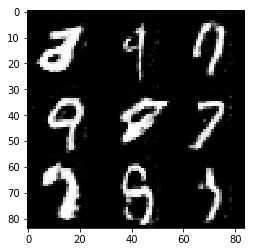

Epoch 2/2... Discriminator Loss: 0.2983... Generator Loss: 2.2512
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 3.0301
Epoch 2/2... Discriminator Loss: 0.3538... Generator Loss: 1.8534
Epoch 2/2... Discriminator Loss: 0.4220... Generator Loss: 1.5772
Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 0.0775... Generator Loss: 5.3470
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.4386
Epoch 2/2... Discriminator Loss: 0.2770... Generator Loss: 1.9218


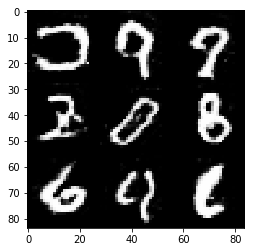

Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 1.5786
Epoch 2/2... Discriminator Loss: 0.2240... Generator Loss: 2.6117
Epoch 2/2... Discriminator Loss: 0.3545... Generator Loss: 1.8566
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 3.1210
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.1054... Generator Loss: 3.6496
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 5.5479
Epoch 2/2... Discriminator Loss: 3.8132... Generator Loss: 0.1407
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 1.2267


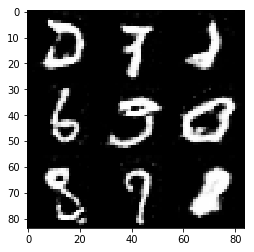

Epoch 2/2... Discriminator Loss: 0.3042... Generator Loss: 2.1122
Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 0.9447
Epoch 2/2... Discriminator Loss: 0.2877... Generator Loss: 2.1465
Epoch 2/2... Discriminator Loss: 0.2442... Generator Loss: 2.3790
Epoch 2/2... Discriminator Loss: 0.2199... Generator Loss: 2.4445
Epoch 2/2... Discriminator Loss: 0.1654... Generator Loss: 2.9056
Epoch 2/2... Discriminator Loss: 0.2782... Generator Loss: 2.6372
Epoch 2/2... Discriminator Loss: 0.2938... Generator Loss: 1.9367
Epoch 2/2... Discriminator Loss: 0.3957... Generator Loss: 2.1575
Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 1.6400


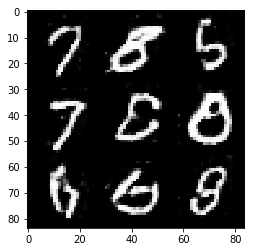

Epoch 2/2... Discriminator Loss: 0.5133... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 0.3757... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 1.6324
Epoch 2/2... Discriminator Loss: 0.4324... Generator Loss: 1.4515
Epoch 2/2... Discriminator Loss: 0.1814... Generator Loss: 2.7497
Epoch 2/2... Discriminator Loss: 0.2947... Generator Loss: 1.7666
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 1.9342


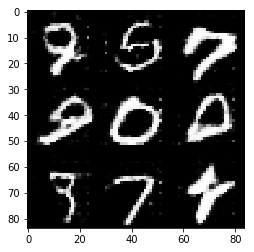

Epoch 2/2... Discriminator Loss: 3.7395... Generator Loss: 7.7863
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 2.3323
Epoch 2/2... Discriminator Loss: 0.8767... Generator Loss: 1.1311
Epoch 2/2... Discriminator Loss: 0.3174... Generator Loss: 2.0624
Epoch 2/2... Discriminator Loss: 0.4810... Generator Loss: 1.6676
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.4273
Epoch 2/2... Discriminator Loss: 0.0970... Generator Loss: 4.2181
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 1.2421


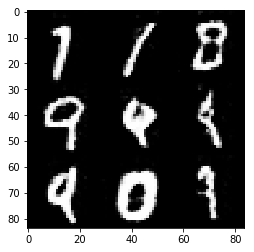

Epoch 2/2... Discriminator Loss: 1.5829... Generator Loss: 0.3325
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 1.9597
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.4134
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 1.5575... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 0.2238... Generator Loss: 3.5071
Epoch 2/2... Discriminator Loss: 0.1715... Generator Loss: 3.0798
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 1.5494


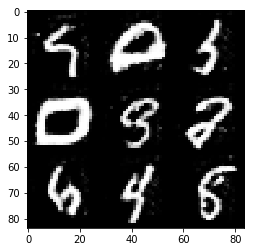

Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.4666
Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 3.2233
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 3.5776
Epoch 2/2... Discriminator Loss: 0.2631... Generator Loss: 1.9446
Epoch 2/2... Discriminator Loss: 0.2538... Generator Loss: 2.7823
Epoch 2/2... Discriminator Loss: 0.1622... Generator Loss: 2.9360
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.2792
Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 1.6258


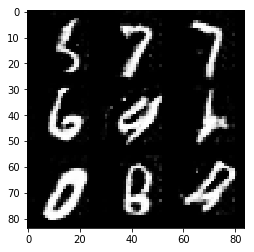

Epoch 2/2... Discriminator Loss: 0.2471... Generator Loss: 5.1277
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.3844
Epoch 2/2... Discriminator Loss: 0.4711... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 0.1883... Generator Loss: 2.4343
Epoch 2/2... Discriminator Loss: 0.2095... Generator Loss: 2.7151
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 1.5877
Epoch 2/2... Discriminator Loss: 0.3058... Generator Loss: 2.2167
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 2.6580
Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.7453
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6463


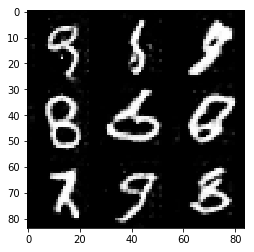

Epoch 2/2... Discriminator Loss: 0.3170... Generator Loss: 2.3059
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 1.5036
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.3156
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.9915
Epoch 2/2... Discriminator Loss: 0.4369... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.1642... Generator Loss: 2.9638
Epoch 2/2... Discriminator Loss: 0.7054... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 1.9143
Epoch 2/2... Discriminator Loss: 0.3058... Generator Loss: 2.4366
Epoch 2/2... Discriminator Loss: 0.2772... Generator Loss: 3.7625


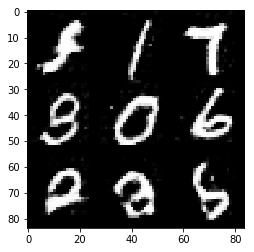

Epoch 2/2... Discriminator Loss: 0.1077... Generator Loss: 3.6893
Epoch 2/2... Discriminator Loss: 0.6272... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.1048
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 2.0938
Epoch 2/2... Discriminator Loss: 0.1812... Generator Loss: 2.8157
Epoch 2/2... Discriminator Loss: 0.3190... Generator Loss: 4.8003
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 6.4757
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 0.3372... Generator Loss: 2.0945
Epoch 2/2... Discriminator Loss: 0.2656... Generator Loss: 2.5696


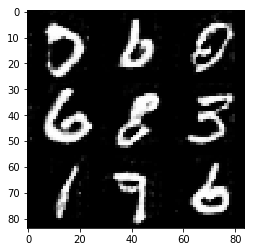

Epoch 2/2... Discriminator Loss: 0.2570... Generator Loss: 1.9388
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 2.1596
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 0.2202... Generator Loss: 2.8822
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 1.7547
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.2946
Epoch 2/2... Discriminator Loss: 0.2915... Generator Loss: 1.8325
Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 1.7614
Epoch 2/2... Discriminator Loss: 1.5753... Generator Loss: 0.4178
Epoch 2/2... Discriminator Loss: 0.1794... Generator Loss: 2.6344


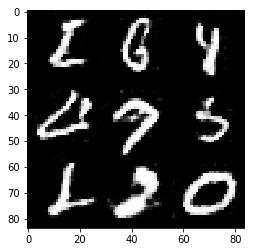

Epoch 2/2... Discriminator Loss: 0.2572... Generator Loss: 2.2091
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 4.6784
Epoch 2/2... Discriminator Loss: 0.1700... Generator Loss: 2.7630
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.7530
Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 1.6173
Epoch 2/2... Discriminator Loss: 0.1557... Generator Loss: 3.1439
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.5215
Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 1.4253
Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.3255... Generator Loss: 2.1491


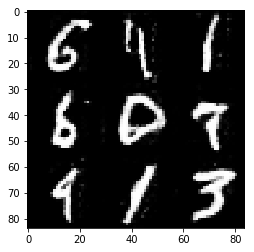

Epoch 2/2... Discriminator Loss: 0.5728... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 2.8890... Generator Loss: 0.2712
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 0.3009... Generator Loss: 1.9718
Epoch 2/2... Discriminator Loss: 0.2102... Generator Loss: 2.1689
Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 0.0991... Generator Loss: 3.7176
Epoch 2/2... Discriminator Loss: 0.3103... Generator Loss: 1.8787


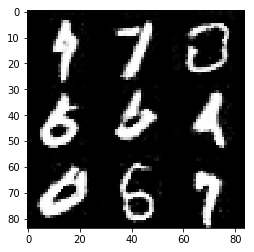

Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 2.4549
Epoch 2/2... Discriminator Loss: 0.1970... Generator Loss: 2.5800
Epoch 2/2... Discriminator Loss: 0.3604... Generator Loss: 1.5617
Epoch 2/2... Discriminator Loss: 0.2530... Generator Loss: 5.3732
Epoch 2/2... Discriminator Loss: 0.2484... Generator Loss: 2.5229
Epoch 2/2... Discriminator Loss: 0.3634... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.1901... Generator Loss: 2.7601
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 1.2308


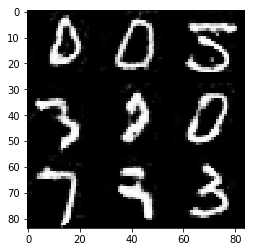

Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 2.2533
Epoch 2/2... Discriminator Loss: 0.2671... Generator Loss: 1.8818
Epoch 2/2... Discriminator Loss: 1.7887... Generator Loss: 0.2662
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 2.1185
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 1.5561
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 0.5904
Epoch 2/2... Discriminator Loss: 0.1850... Generator Loss: 2.3857
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7064


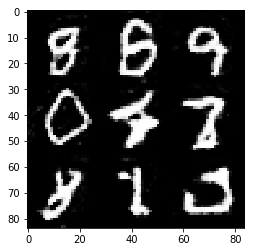

Epoch 2/2... Discriminator Loss: 0.2213... Generator Loss: 2.3750
Epoch 2/2... Discriminator Loss: 2.3442... Generator Loss: 0.1432
Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 1.8325
Epoch 2/2... Discriminator Loss: 0.1776... Generator Loss: 2.6068
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.1480... Generator Loss: 2.9062
Epoch 2/2... Discriminator Loss: 0.3235... Generator Loss: 2.4348
Epoch 2/2... Discriminator Loss: 0.1777... Generator Loss: 3.3472
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.2215
Epoch 2/2... Discriminator Loss: 0.2219... Generator Loss: 2.4087


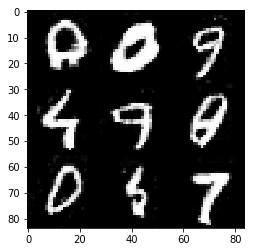

Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 0.2999... Generator Loss: 2.2381
Epoch 2/2... Discriminator Loss: 0.1617... Generator Loss: 3.2046
Epoch 2/2... Discriminator Loss: 0.2769... Generator Loss: 2.3103
Epoch 2/2... Discriminator Loss: 0.2252... Generator Loss: 2.6350
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 0.2359... Generator Loss: 2.2503
Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 2.1589
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.6285


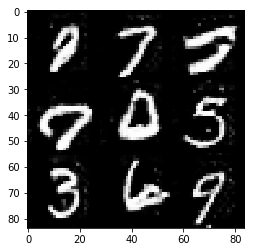

Epoch 2/2... Discriminator Loss: 0.3151... Generator Loss: 1.8933
Epoch 2/2... Discriminator Loss: 0.2116... Generator Loss: 2.2551
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 1.6026
Epoch 2/2... Discriminator Loss: 0.0843... Generator Loss: 6.1011
Epoch 2/2... Discriminator Loss: 0.2543... Generator Loss: 2.1889
Epoch 2/2... Discriminator Loss: 0.1252... Generator Loss: 3.7428
Epoch 2/2... Discriminator Loss: 0.2275... Generator Loss: 2.3025
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 1.4379
Epoch 2/2... Discriminator Loss: 0.2041... Generator Loss: 2.6833
Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.5903


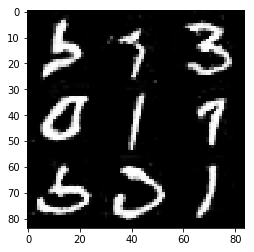

In [28]:
batch_size = 10
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 1.6487
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 2.8236
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 9.7584
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 7.7942
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 4.3445
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 1.8844... Generator Loss: 0.3443


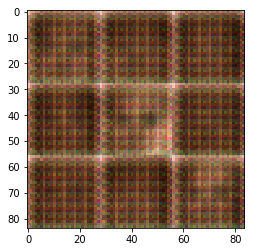

Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 1.5094
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 2.3334... Generator Loss: 5.1356
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.9578
Epoch 1/1... Discriminator Loss: 1.8450... Generator Loss: 0.2645


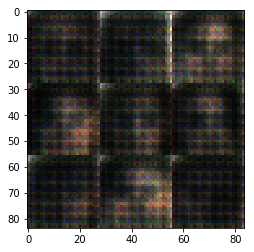

Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.9452
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.8728
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 3.0584
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.1844


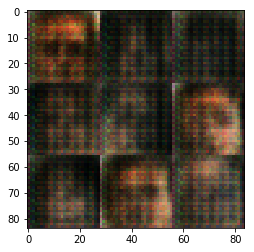

Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 2.0402
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 2.8600
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.5299
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.3551
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 2.8824
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.9223... Generator Loss: 3.2275


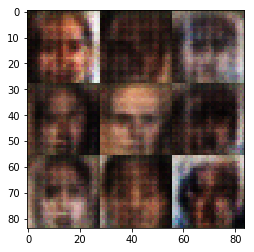

Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 3.5437
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 3.2913
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 3.2302
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.5221
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.5052
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.7720


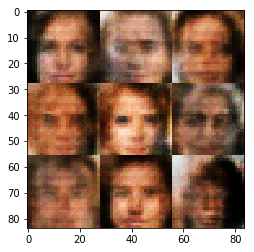

Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.2742
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 3.1670
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 0.3053
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 1.6309
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 0.9347


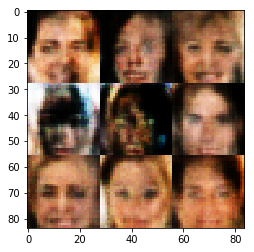

Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 2.1632
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 4.3486
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 3.8039
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 3.9522
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.6510
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 6.6717
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 5.6462
Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 5.6907
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.5587


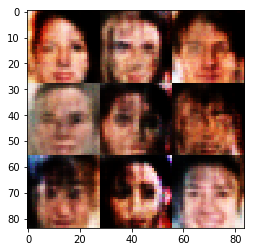

Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 2.9848
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 5.2568
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 5.4396
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 0.2527
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 4.4353
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 3.5862
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 4.4007
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 2.7590


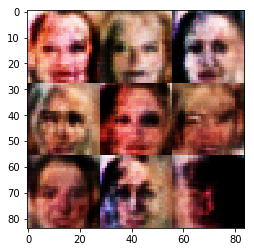

Epoch 1/1... Discriminator Loss: 2.2708... Generator Loss: 4.5563
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 5.2924
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 2.3398
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.6961
Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 4.2446
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 2.4056
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 3.0981
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.1742


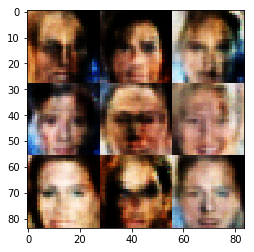

Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 2.4882
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 3.0241
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.7771
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.9709
Epoch 1/1... Discriminator Loss: 0.2782... Generator Loss: 2.6527
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 3.0250
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.6312
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.1052


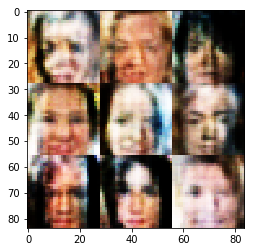

Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 1.7872
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 1.9779
Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 3.3663
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 2.8643
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 7.1127
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.9788
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 1.7171
Epoch 1/1... Discriminator Loss: 0.2763... Generator Loss: 2.2507


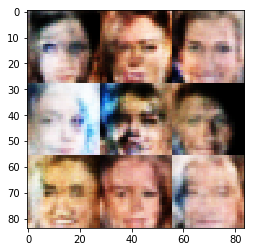

Epoch 1/1... Discriminator Loss: 0.2685... Generator Loss: 2.3615
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.6528
Epoch 1/1... Discriminator Loss: 0.2443... Generator Loss: 2.7294
Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 3.0192
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 4.3694
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 2.8130
Epoch 1/1... Discriminator Loss: 0.2696... Generator Loss: 2.0851


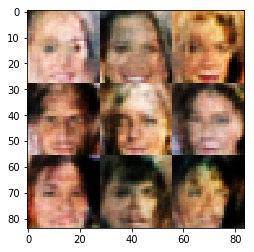

Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 4.3323
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.7902
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 2.0971... Generator Loss: 0.1918
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 4.8163


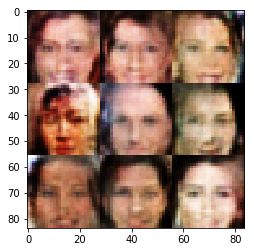

Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 3.9993
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 1.8601
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 3.4442
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 3.1238
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 2.5928
Epoch 1/1... Discriminator Loss: 2.3566... Generator Loss: 0.1843
Epoch 1/1... Discriminator Loss: 2.2104... Generator Loss: 4.6565
Epoch 1/1... Discriminator Loss: 3.0186... Generator Loss: 5.2364
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 3.8427


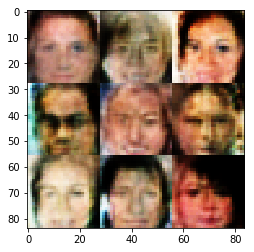

Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 4.1455
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 3.7377
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 3.2002
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 3.6175
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.7417
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 0.3184... Generator Loss: 3.7972
Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.7745


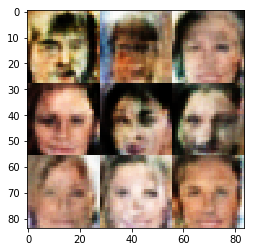

Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 2.4125
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 1.7826
Epoch 1/1... Discriminator Loss: 1.7281... Generator Loss: 0.2862
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 0.9386


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.